Не стоит думать, что кластеризация, это только про тексты. Есть много других применений, например, сегментация пользователей

# Сегментация покупателей

In [2]:
import pandas as pd
import numpy as np
import datetime, zipfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython.display import display

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [26]:
with zipfile.ZipFile('transactions.csv.zip') as zf:
    df_cleaned = pd.read_csv(zf.open('transactions.csv'), parse_dates=['InvoiceDate'])

In [27]:
df_cleaned[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,categ_product
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,4
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,0


# Посчитаем сколько денег было потрачено в каждой категории

In [28]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)


df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,4,0.00,0.0,0.0,0.0,15.3
1,536365,WHITE METAL LANTERN,0,20.34,0.0,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,0,22.00,0.0,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,0,20.34,0.0,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,0,20.34,0.0,0.0,0.0,0.0


# Сгруппируем по каждому заказу для клиента

In [29]:
basket_price = df_cleaned.groupby(['CustomerID', 'InvoiceNo', 'InvoiceDate'])[['categ_{}'.format(i) for i in range(5)]].sum()
basket_price['Basket Price'] = basket_price.sum(1)
basket_price.reset_index(inplace=True)
basket_price = basket_price[basket_price['Basket Price'] > 0]

basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,InvoiceDate,categ_0,categ_1,categ_2,categ_3,categ_4,Basket Price
1,12347,537626,2010-12-07 14:57:00,293.35,23.40,187.2,124.44,83.40,711.79
2,12347,542237,2011-01-26 14:30:00,169.20,84.34,130.5,0.00,91.35,475.39
3,12347,549222,2011-04-07 10:43:00,115.00,81.00,330.9,0.00,109.35,636.25
4,12347,556201,2011-06-09 13:01:00,168.76,41.40,74.4,19.90,78.06,382.52
5,12347,562032,2011-08-02 08:48:00,158.16,61.30,109.7,97.80,157.95,584.91


Теперь сгруппируем посчитанные статистики по каждому клиенту. Добавим признаки, описывающие пользователя, такие как: число покупок, сделанных пользователем, минимальная/максимальная/средняя стоимость покупки.

In [30]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
# basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,7,224.82,1294.32,615.714286,4310.00,29.540371,11.237123,26.375870,7.604176,25.242459
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,38.016069,41.953217,0.000000,20.030714
2,12349,1,1757.55,1757.55,1757.550000,1757.55,10.713778,4.513101,26.506216,20.389178,37.877728
3,12350,1,334.40,334.40,334.400000,334.40,0.000000,11.692584,48.444976,0.000000,39.862440
4,12352,7,144.35,840.30,340.815714,2385.71,14.601523,1.299404,15.705178,14.691643,53.702252


Добавим также следующие признаки: число дней прошедших с первой и последней покупок

In [31]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,29.540371,11.237123,26.375870,7.604176,25.242459,2,367
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,38.016069,41.953217,0.000000,20.030714,75,358
2,12349,1,1757.55,1757.55,1757.550000,1757.55,10.713778,4.513101,26.506216,20.389178,37.877728,18,18
3,12350,1,334.40,334.40,334.400000,334.40,0.000000,11.692584,48.444976,0.000000,39.862440,310,310
4,12352,7,144.35,840.30,340.815714,2385.71,14.601523,1.299404,15.705178,14.691643,53.702252,36,296


Нам могут быть особенно интересны клиенты, которые сделали только одну покупку. Посмотрим, сколько их:

In [32]:
(transactions_per_user['count'] == 1).mean()

0.34365611278021724

# Кластеризуем пользователей

In [33]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

matrix = transactions_per_user[list_cols].values

Нормируем признаки

In [34]:
scaler = StandardScaler()
scaler.fit(matrix)
scaled_matrix = scaler.transform(matrix)

## Кластеризуем с помощью Kmeans

In [35]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)

## Размер кластеров

In [36]:
pd.Series(clusters_clients).value_counts()

10    1843
3      613
0      433
1      363
4      360
6      305
2      193
9      181
7       17
5       12
8        7
dtype: int64

## Проверим, что кластеры отделены друг от друга

Для этого нам нужно как-то отобразить наши кластера. Что может нам здесь помочь?

### PCA

In [37]:
pca = PCA(n_components=2)
mat = pca.fit_transform(scaled_matrix)

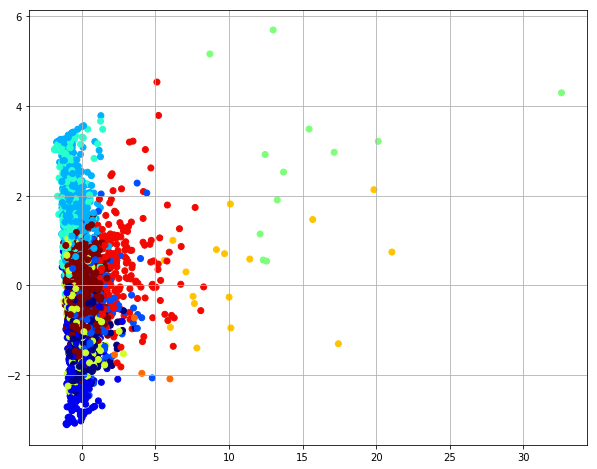

In [38]:
plt.figure(figsize=(10,8))
plt.scatter(mat[:,0], mat[:,1], c=clusters_clients, alpha=1);
plt.set_cmap('jet')
plt.grid()

### TSNE

In [39]:
%%time
from sklearn.manifold import TSNE
mat = TSNE().fit_transform(scaled_matrix)

CPU times: user 37.7 s, sys: 2.24 s, total: 39.9 s
Wall time: 42.7 s


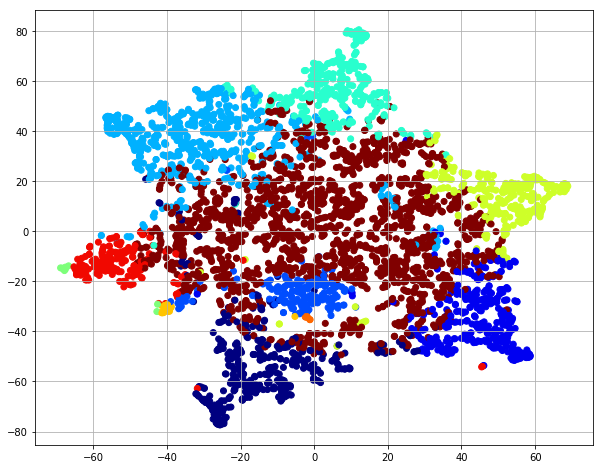

In [40]:
plt.figure(figsize=(10,8))
plt.scatter(mat[:,0], mat[:,1], c=clusters_clients, alpha=1);
plt.set_cmap('jet')
plt.grid()

## Что из себя представляют кластеры?

In [41]:
selected_customers = transactions_per_user.copy()
selected_customers.loc[:, 'cluster'] = clusters_clients

In [42]:
merged_df = selected_customers.groupby('cluster').mean()
del merged_df['CustomerID']
merged_df

,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
cluster,,,,,,,,,,,,
0,2.699769,199.456836,374.160046,279.089589,845.260092,7.196808,5.407792,11.467370,7.910000,68.018030,127.101617,224.330254
1,2.958678,189.513967,335.026336,256.582615,790.465455,12.750644,5.452524,10.916703,51.903325,18.976804,134.198347,236.705234
2,21.269430,71.174767,1370.957513,484.242590,10055.247979,17.092455,11.744339,23.476406,15.591827,32.094973,12.326425,348.797927
3,2.758564,207.795204,355.571680,276.112106,788.164325,8.740056,13.166148,54.437476,5.562725,18.093595,106.812398,201.076672
4,2.363889,185.842056,315.541750,240.564608,608.524722,7.608426,50.809123,20.670191,6.060661,14.851599,105.136111,191.736111
5,1.500000,4075.741667,6245.503333,5073.737778,7931.028333,15.135140,19.206717,18.218655,12.841314,34.598174,89.833333,123.583333
6,2.655738,196.047803,358.532459,268.029810,866.338262,53.702878,6.834554,13.373734,9.410585,16.678249,104.150820,194.098361
7,31.117647,85.434118,13750.221765,3019.472832,90558.188235,18.540635,8.862735,20.021898,15.226721,37.348011,23.764706,336.705882
8,127.857143,10.128571,2248.087143,380.981286,49674.560000,14.283534,13.882153,25.283152,17.035598,29.515563,1.142857,372.285714


## Визуализируем каждый кластер

In [19]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


This allows to have a global view of the content of each cluster:

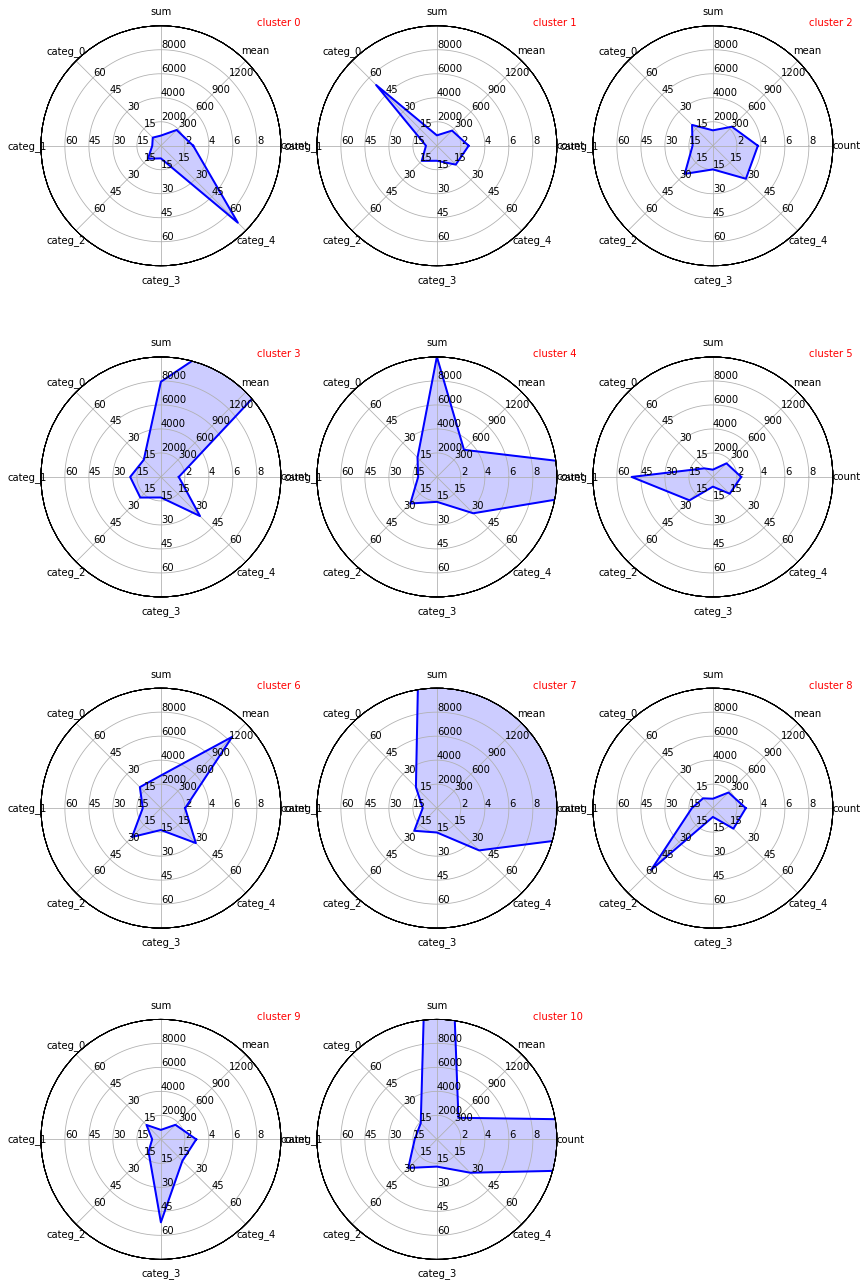

In [20]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1./i_cols), (1./i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = u'cluster {}'.format(index[ind]), color = 'r')
    ind += 1 